## Training word embeddings on Harry Potter books corpus

In [1]:
# bridging Python versions
from __future__ import absolute_import, division, print_function

In [2]:
# for openning and processing the data files
import codecs # encoding the corpus into utf-8
import glob  # Unix style pathname pattern
import logging
import multiprocessing
from joblib import Parallel, delayed  # for parallel computation
import os
import re
import time

In [3]:
import nltk  # for text cleaning
from gensim.models.phrases import Phraser, Phrases
from gensim.models import Word2Vec, FastText  # the models used for word embeddings

In [4]:
# for plotting and analyzing the results

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.manifold import TSNE # for dimensionality reduction to plot similar words

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### setting up the logging

In [6]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Downloading the tokenizer model from nltk

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ammar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Loading Harry Potter books

In [8]:
book_names = sorted(glob.glob("data/*.txt"))
book_names

['data/hp1.txt',
 'data/hp2.txt',
 'data/hp3.txt',
 'data/hp4.txt',
 'data/hp5.txt',
 'data/hp6.txt',
 'data/hp7.txt']

#### create one string of all the books

In [9]:
raw_corpus = u""  # will use utf-8
for filename in book_names:
    print("Reading {}...".format(filename.split("/")[1]))
    with codecs.open(filename,"r","utf-8") as book:
        raw_corpus += book.read() 
    print("Corpus now is {} characters and {} words long".format(len(raw_corpus), len(raw_corpus.split())))
    print("~"*30)

Reading hp1.txt...
Corpus now is 442745 characters and 78449 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp2.txt...
Corpus now is 932472 characters and 165674 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp3.txt...
Corpus now is 1543433 characters and 271749 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp4.txt...
Corpus now is 2650206 characters and 467521 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp5.txt...
Corpus now is 4131978 characters and 726862 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp6.txt...
Corpus now is 5117585 characters and 900224 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reading hp7.txt...
Corpus now is 6250142 characters and 1100343 words long
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### loading the tokenizer

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(raw_corpus.lower())

In [12]:
raw_sentences[:2]

["harry potter and the sorcerer's stone \n\nchapter one \n\nthe boy who lived \n\nmr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much.",
 "they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense."]

In [13]:
def sentence_to_wordlist(raw:str):
    return re.sub("[^a-zA-Z]"," ", raw).split()

In [14]:
# converting sentences to wordlists, utilizing all the cpu cores
tokenized_sentences = Parallel(n_jobs=-1)(
                delayed(sentence_to_wordlist)(
                    raw_sentence) for raw_sentence in raw_sentences)

In [14]:
print(raw_sentences[10])
print(tokenized_sentences[10])

the dursleys knew that the potters had a small son, too, but they had never even seen him.
['the', 'dursleys', 'knew', 'that', 'the', 'potters', 'had', 'a', 'small', 'son', 'too', 'but', 'they', 'had', 'never', 'even', 'seen', 'him']


# Word2Phrase
## e.g. new_york_city

In [15]:
phrases = Phrases(tokenized_sentences)

2018-07-02 22:46:57,897 : INFO : collecting all words and their counts
2018-07-02 22:46:57,899 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-07-02 22:46:58,147 : INFO : PROGRESS: at sentence #10000, processed 128427 words and 62790 word types
2018-07-02 22:46:58,332 : INFO : PROGRESS: at sentence #20000, processed 257842 words and 105427 word types
2018-07-02 22:46:58,507 : INFO : PROGRESS: at sentence #30000, processed 377963 words and 139813 word types
2018-07-02 22:46:58,669 : INFO : PROGRESS: at sentence #40000, processed 487238 words and 167134 word types
2018-07-02 22:46:58,886 : INFO : PROGRESS: at sentence #50000, processed 640144 words and 205287 word types
2018-07-02 22:46:59,119 : INFO : PROGRESS: at sentence #60000, processed 793495 words and 240556 word types
2018-07-02 22:46:59,325 : INFO : PROGRESS: at sentence #70000, processed 925964 words and 270064 word types
2018-07-02 22:46:59,507 : INFO : PROGRESS: at sentence #80000, processed 1055555

In [16]:
bigram = Phraser(phrases)

2018-07-02 22:46:59,605 : INFO : source_vocab length 310226
2018-07-02 22:47:02,236 : INFO : Phraser built with 2238 2238 phrasegrams


In [17]:
sentences = list(bigram[tokenized_sentences])

In [18]:
tokens_count = sum([len(sen) for sen in sentences])
no_bigram_count = sum([len(s) for s in tokenized_sentences])
print("""This corpus has:\n
                {0:,} tokens with bigrams\n
                {1:,} tokens without bigrams\n
                {2:} of the tokens have been included in phrases""".format(
    tokens_count,no_bigram_count, 1-tokens_count/no_bigram_count))

This corpus has:

                1,048,809 tokens with bigrams

                1,120,879 tokens without bigrams

                0.06429775203211052 of the tokens have been included in phrases


### Setting models parameters

In [19]:
workers = multiprocessing.cpu_count()
min_word_count = 3
features_count = 300
window_size = 5
subsampling = 0.001
seed = 48 # the answer to the universe is ... 48 :D

In [20]:
workers

8

# Word2Vec
## CBOW

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
start = time.time()
w2v_cbow = Word2Vec(sentences=sentences, size=300, window=7, min_count=3, workers=workers, sg=0, seed=seed)
print("Training Word2Vec CBOW took {} seconds".format(time.time()-start))

2018-07-02 22:47:04,969 : INFO : collecting all words and their counts
2018-07-02 22:47:04,969 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-02 22:47:04,989 : INFO : PROGRESS: at sentence #10000, processed 119862 words, keeping 9022 word types
2018-07-02 22:47:05,010 : INFO : PROGRESS: at sentence #20000, processed 240769 words, keeping 12609 word types
2018-07-02 22:47:05,028 : INFO : PROGRESS: at sentence #30000, processed 352505 words, keeping 15136 word types
2018-07-02 22:47:05,044 : INFO : PROGRESS: at sentence #40000, processed 454534 words, keeping 16749 word types
2018-07-02 22:47:05,067 : INFO : PROGRESS: at sentence #50000, processed 597114 words, keeping 18902 word types
2018-07-02 22:47:05,093 : INFO : PROGRESS: at sentence #60000, processed 740694 words, keeping 20656 word types
2018-07-02 22:47:05,114 : INFO : PROGRESS: at sentence #70000, processed 864976 words, keeping 22380 word types
2018-07-02 22:47:05,135 : INFO : PROGRESS: at s

Training Word2Vec CBOW took 3.493960380554199 seconds


In [23]:
w2v_cbow.save(os.path.join("trained", "w2v_cbow.bin"))

2018-07-02 22:47:08,469 : INFO : saving Word2Vec object under trained/w2v_cbow.bin, separately None
2018-07-02 22:47:08,470 : INFO : not storing attribute syn0norm
2018-07-02 22:47:08,471 : INFO : not storing attribute cum_table
2018-07-02 22:47:08,736 : INFO : saved trained/w2v_cbow.bin


## Skip-Gram

In [24]:
start = time.time()
w2v_sg = Word2Vec(sentences=sentences, size=300, window=7, min_count=3, workers=workers, sg=1, seed=seed)
print("Training Word2Vec Skip-Gram took {} seconds".format(time.time()-start))

2018-07-02 22:47:08,741 : INFO : collecting all words and their counts
2018-07-02 22:47:08,741 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-02 22:47:08,760 : INFO : PROGRESS: at sentence #10000, processed 119862 words, keeping 9022 word types
2018-07-02 22:47:08,779 : INFO : PROGRESS: at sentence #20000, processed 240769 words, keeping 12609 word types
2018-07-02 22:47:08,797 : INFO : PROGRESS: at sentence #30000, processed 352505 words, keeping 15136 word types
2018-07-02 22:47:08,812 : INFO : PROGRESS: at sentence #40000, processed 454534 words, keeping 16749 word types
2018-07-02 22:47:08,833 : INFO : PROGRESS: at sentence #50000, processed 597114 words, keeping 18902 word types
2018-07-02 22:47:08,855 : INFO : PROGRESS: at sentence #60000, processed 740694 words, keeping 20656 word types
2018-07-02 22:47:08,875 : INFO : PROGRESS: at sentence #70000, processed 864976 words, keeping 22380 word types
2018-07-02 22:47:08,896 : INFO : PROGRESS: at s

Training Word2Vec Skip-Gram took 7.785972595214844 seconds


In [25]:
w2v_sg.save(os.path.join("trained", "w2v_sg.bin"))

2018-07-02 22:47:16,530 : INFO : saving Word2Vec object under trained/w2v_sg.bin, separately None
2018-07-02 22:47:16,531 : INFO : not storing attribute syn0norm
2018-07-02 22:47:16,531 : INFO : not storing attribute cum_table
2018-07-02 22:47:16,796 : INFO : saved trained/w2v_sg.bin


# FastText
## CBOW

In [26]:
start = time.time()
fasttext_cbow = FastText(sentences, size=300, window=7, min_count=3, workers=workers,sg=0, seed=seed)
print("Training FastText CBOW took {} seconds".format(time.time()-start))

2018-07-02 22:47:16,800 : INFO : collecting all words and their counts
2018-07-02 22:47:16,801 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-02 22:47:16,818 : INFO : PROGRESS: at sentence #10000, processed 119862 words, keeping 9022 word types
2018-07-02 22:47:16,837 : INFO : PROGRESS: at sentence #20000, processed 240769 words, keeping 12609 word types
2018-07-02 22:47:16,853 : INFO : PROGRESS: at sentence #30000, processed 352505 words, keeping 15136 word types
2018-07-02 22:47:16,870 : INFO : PROGRESS: at sentence #40000, processed 454534 words, keeping 16749 word types
2018-07-02 22:47:16,890 : INFO : PROGRESS: at sentence #50000, processed 597114 words, keeping 18902 word types
2018-07-02 22:47:16,915 : INFO : PROGRESS: at sentence #60000, processed 740694 words, keeping 20656 word types
2018-07-02 22:47:16,936 : INFO : PROGRESS: at sentence #70000, processed 864976 words, keeping 22380 word types
2018-07-02 22:47:16,954 : INFO : PROGRESS: at s

Training FastText CBOW took 35.185463428497314 seconds


In [27]:
fasttext_cbow.save(os.path.join("trained", "fasttext_cbow.bin"))

2018-07-02 22:47:51,990 : INFO : saving FastText object under trained/fasttext_cbow.bin, separately None
2018-07-02 22:47:51,990 : INFO : not storing attribute syn0_vocab_norm
2018-07-02 22:47:51,991 : INFO : storing np array 'syn0_ngrams' to trained/fasttext_cbow.bin.wv.syn0_ngrams.npy
2018-07-02 22:47:52,059 : INFO : not storing attribute syn0norm
2018-07-02 22:47:52,059 : INFO : not storing attribute syn0_ngrams_norm
2018-07-02 22:47:52,060 : INFO : storing np array 'syn0_ngrams_lockf' to trained/fasttext_cbow.bin.syn0_ngrams_lockf.npy
2018-07-02 22:47:53,011 : INFO : saved trained/fasttext_cbow.bin


In [28]:
start = time.time()
fasttext_sg = FastText(sentences, size=300, window=7, min_count=3, workers=workers,sg=1, seed=seed)
print("Training FastText CBOW took {} seconds".format(time.time()-start))

2018-07-02 22:47:53,016 : INFO : collecting all words and their counts
2018-07-02 22:47:53,017 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-02 22:47:53,036 : INFO : PROGRESS: at sentence #10000, processed 119862 words, keeping 9022 word types
2018-07-02 22:47:53,054 : INFO : PROGRESS: at sentence #20000, processed 240769 words, keeping 12609 word types
2018-07-02 22:47:53,072 : INFO : PROGRESS: at sentence #30000, processed 352505 words, keeping 15136 word types
2018-07-02 22:47:53,089 : INFO : PROGRESS: at sentence #40000, processed 454534 words, keeping 16749 word types
2018-07-02 22:47:53,111 : INFO : PROGRESS: at sentence #50000, processed 597114 words, keeping 18902 word types
2018-07-02 22:47:53,132 : INFO : PROGRESS: at sentence #60000, processed 740694 words, keeping 20656 word types
2018-07-02 22:47:53,152 : INFO : PROGRESS: at sentence #70000, processed 864976 words, keeping 22380 word types
2018-07-02 22:47:53,169 : INFO : PROGRESS: at s

Training FastText CBOW took 39.9210045337677 seconds


In [29]:
fasttext_sg.save(os.path.join("trained", "fasttext_sg.bin"))

2018-07-02 22:48:32,940 : INFO : saving FastText object under trained/fasttext_sg.bin, separately None
2018-07-02 22:48:32,941 : INFO : not storing attribute syn0_vocab_norm
2018-07-02 22:48:32,942 : INFO : storing np array 'syn0_ngrams' to trained/fasttext_sg.bin.wv.syn0_ngrams.npy
2018-07-02 22:48:33,010 : INFO : not storing attribute syn0norm
2018-07-02 22:48:33,010 : INFO : not storing attribute syn0_ngrams_norm
2018-07-02 22:48:33,011 : INFO : storing np array 'syn0_ngrams_lockf' to trained/fasttext_sg.bin.syn0_ngrams_lockf.npy
2018-07-02 22:48:33,950 : INFO : saved trained/fasttext_sg.bin


# Exploring the trained models
### Semantic similarities

In [30]:
fasttext_sg.most_similar("man")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-07-02 22:48:33,954 : INFO : precomputing L2-norms of word weight vectors
2018-07-02 22:48:33,973 : INFO : precomputing L2-norms of ngram weight vectors


[('woman', 0.8535742163658142),
 ('old_woman', 0.8125366568565369),
 ('old_man', 0.8057711124420166),
 ('madman', 0.8023333549499512),
 ('barman', 0.8000619411468506),
 ('merman', 0.7923632860183716),
 ('talisman', 0.7884429693222046),
 ('boy', 0.767625093460083),
 ('young_man', 0.7610684633255005),
 ('mane', 0.7569593787193298)]

In [31]:
w2v_sg.most_similar("man")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-07-02 22:48:35,018 : INFO : precomputing L2-norms of word weight vectors


[('wizard', 0.7468042969703674),
 ('boy', 0.728783369064331),
 ('old_man', 0.7119756937026978),
 ('woman', 0.7097409963607788),
 ('ugly', 0.7028669118881226),
 ('creature', 0.6771330833435059),
 ('skinny', 0.6757481098175049),
 ('child', 0.6734893918037415),
 ('gaunt', 0.6703120470046997),
 ('nosed', 0.666618824005127)]

In [32]:
fasttext_sg.most_similar("wizard")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lizard', 0.9143307209014893),
 ('wizardkind', 0.9103794097900391),
 ('wiz', 0.9028722047805786),
 ('wizardry', 0.8854329586029053),
 ('triwizard', 0.8668864369392395),
 ('dark_wizard', 0.8515946865081787),
 ('wizard_chess', 0.8342143893241882),
 ('greatest_wizard', 0.8299335241317749),
 ('balding_wizard', 0.8259945511817932),
 ('wizard_prison', 0.8133100271224976)]

In [33]:
w2v_sg.most_similar("wizard")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('witch', 0.7799991369247437),
 ('man', 0.7468042969703674),
 ('house_elf', 0.7278867959976196),
 ('witch_or', 0.7212192416191101),
 ('boy', 0.6939235925674438),
 ('lady', 0.6722564101219177),
 ('skinny', 0.6555918455123901),
 ('child', 0.652462363243103),
 ('thief', 0.6514541506767273),
 ('muggle_born', 0.6514096260070801)]

In [34]:
fasttext_sg.most_similar("harry")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('harrys', 0.8619028925895691),
 ('harrys_heart', 0.8022904396057129),
 ('barry', 0.7698321342468262),
 ('harp', 0.7440785765647888),
 ('harold', 0.7303733825683594),
 ('tarry', 0.7272648811340332),
 ('mr_diggory', 0.7242087125778198),
 ('harshly', 0.7237054109573364),
 ('harper', 0.7083446979522705),
 ('xenophilius', 0.7064019441604614)]

In [35]:
w2v_sg.most_similar("harry")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mr_diggory', 0.69838547706604),
 ('ernie', 0.6874744296073914),
 ('colin', 0.6812676787376404),
 ('xenophilius', 0.677889883518219),
 ('mr_ollivander', 0.6705306768417358),
 ('he', 0.6668051481246948),
 ('krum', 0.6658759713172913),
 ('professor_lupin', 0.6616381406784058),
 ('mclaggen', 0.6531736254692078),
 ('encouragingly', 0.6528182029724121)]

## Plotting word vectors
### reducing dimensions to 2-D for plotting, using T-SNE

In [36]:
tsne = TSNE(n_components=2, random_state=seed)

In [37]:
word_vectors = w2v_sg.wv.syn0

In [38]:
start = time.time()
word_vectors_2d = tsne.fit_transform(word_vectors)
print("Reducing dimensions to 2-D using T-SNE took {} seconds".format(time.time()-start))

Reducing dimensions to 2-D using T-SNE took 392.6476743221283 seconds


In [39]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_vectors_2d[fasttext_sg.wv.vocab[word].index])
            for word in fasttext_sg.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.sample(5)

,word,x,y
3498,vat,-12.303199,-38.903690
2407,fleeting,-23.269794,17.081104
11435,riches,24.507088,-28.907719
7131,contracted,-0.540975,-19.085238
3039,movement,-29.715515,8.015775


In [40]:
sns.set_context("poster")

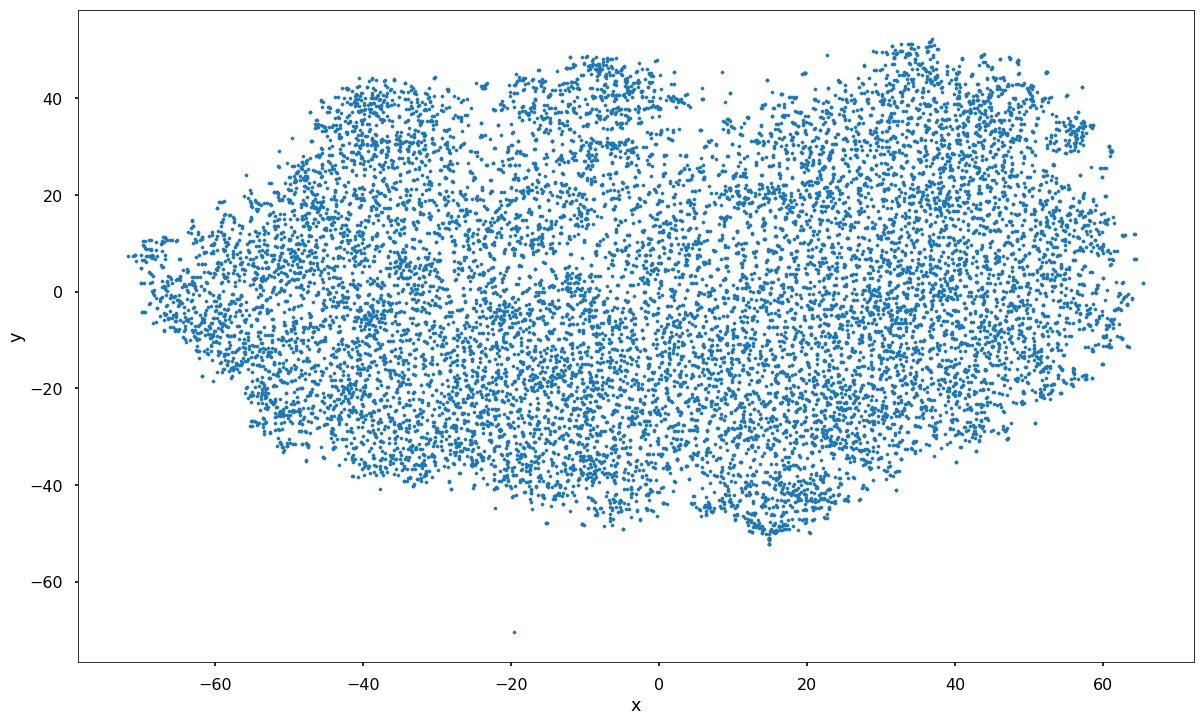

In [41]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Zooming on 'interesting' regions in the plot

In [42]:
def plot_region(x_bounds, y_bounds, padding=0.005, fontsize=11):
    myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = myslice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in myslice.iterrows():
        ax.text(point.x + padding, point.y + padding, point.word, fontsize=fontsize)

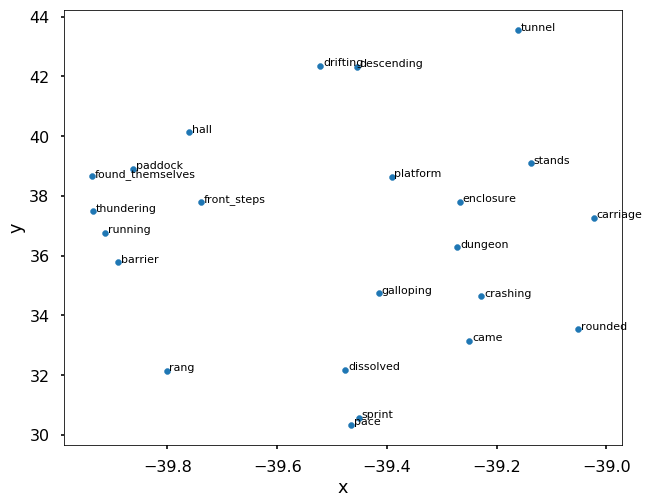

In [43]:
x_bounds = (-40., -39.)
y_bounds = (30., 50.)
myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
len(myslice)
plot_region(x_bounds=x_bounds, y_bounds=y_bounds)